# Mixed Calibration of model parameters: AAPL
### European calls and puts and otko daily cliquet options

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy.optimize as scpo
import sys
import time
import warnings
sys.path.append('C:/Users\ornel\PycharmProjects\Margin-Loans-Pricing/functions')
sys.path.append('C:/Users/ornel/PycharmProjects/Margin-Loans-Pricing/calibration')
warnings.simplefilter(action='ignore', category=FutureWarning)

from BSpricer import BS_Pricer
from MERTONpricer import Merton_pricer
from KOUpricer import Kou_pricer
from VGpricer import VG_pricer

Let's read the dataframe of european call and put options. A **subset** of options has been already selected in the module  `plainvanilla.py`.

In [2]:
calls_aapl = pd.read_csv('../../data/AAPL/OPT16_AAPL_CALLS_50_150.csv')
moneyness = [0.77, 0.90, 1.01, 1.08, 1.24]
cond = calls_aapl['MONEYNESS'].isin(moneyness)
calls = calls_aapl[cond].copy()
calls.reset_index(drop=True, inplace=True)
print(calls)

   QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE  C_BID  C_ASK  STRIKE     C_IV  \
0  2016-01-20            96.79  2017-01-20  25.10  25.50    75.0  0.32883   
1  2016-01-20            96.79  2017-01-20  16.75  17.05    87.5  0.31782   
2  2016-01-20            96.79  2017-01-20  11.55  11.70    97.5  0.30928   
3  2016-01-20            96.79  2017-01-20   8.45   8.61   105.0  0.30361   
4  2016-01-20            96.79  2017-01-20   4.15   4.24   120.0  0.29087   

   MONEYNESS  
0       0.77  
1       0.90  
2       1.01  
3       1.08  
4       1.24  


In [3]:
puts_aapl = pd.read_csv('../../data/AAPL/OPT16_AAPL_PUTS_50_150.csv')
moneyness = [0.72, 0.88, 1.01, 1.14, 1.29]
cond = puts_aapl['MONEYNESS'].isin(moneyness)
puts = puts_aapl[cond].copy()
puts.reset_index(drop=True, inplace=True)
print(puts)

   QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE  P_BID  P_ASK  STRIKE     P_IV  \
0  2016-01-20            96.79  2017-01-20   3.30   3.40    70.0  0.37716   
1  2016-01-20            96.79  2017-01-20   7.50   7.65    85.0  0.34912   
2  2016-01-20            96.79  2017-01-20  13.15  13.36    97.5  0.33399   
3  2016-01-20            96.79  2017-01-20  20.75  20.99   110.0  0.32280   
4  2016-01-20            96.79  2017-01-20  32.06  32.40   125.0  0.31712   

   MONEYNESS  
0       0.72  
1       0.88  
2       1.01  
3       1.14  
4       1.29  


Let's initialize the values for our calibration.

In [4]:
q = 0           # dividend yield
r = 0.03        # risk-free interest rate
S0 = calls.iloc[0]['UNDERLYING_LAST']
T = 1           # time-to-maturity
exercise = 'european'

calls['C_Spread'] = calls['C_BID'] - calls['C_ASK']
calls['C_Midpoint'] = abs(calls['C_BID'] + calls['C_ASK']) / 2
calls_strikes = calls['STRIKE']    # array of K for call options
calls_prices = calls['C_Midpoint']
calls_spreads = calls['C_Spread']
calls_weights = 1/calls_spreads**2

In [5]:
puts['P_Midpoint'] = abs(puts['P_BID'] + puts['P_ASK']) / 2
puts['P_Spread'] = puts['P_BID'] - puts['P_ASK']
puts_strikes = puts['STRIKE']    # array of K for call options
puts_prices = puts['P_Midpoint']
puts_spreads = puts['P_Spread']
weights = 1/puts_spreads**2

In [6]:
otko_aapl = pd.read_csv('../../data/AAPL/aapl_otko_1year.csv')
scale_factors = {
    'AAPL': 7.84,
    'META': 6.23,
    'TSLA': 10.35,
    'NVDA': 10.7
}

th_prices = pd.DataFrame({
    'K1': otko_aapl['K1'],
    'K2': otko_aapl['K2'],
    'Midpoint (%)': otko_aapl['Midpoint(%)']
})
print(otko_aapl)
th_mc_prices = pd.DataFrame({})
th_cf_prices = pd.DataFrame({})

otko_strikes = otko_aapl[['K1', 'K2']].values / 100
otko_spreads =  otko_aapl['ASK(%)'] - otko_aapl['BID(%)']
otko_weights = 1/(otko_spreads) **2
otko_mkt_prices = otko_aapl['Midpoint(%)'].values

  Starting date Stock Name Expiry  K1  K2  BID(%)  Midpoint(%)  ASK(%)
0    20/01/2016       AAPL     1Y  75   0    1.33         1.45    1.57
1    20/01/2016       AAPL     1Y  70   0    0.63         0.71    0.78
2    20/01/2016       AAPL     1Y  85  75    2.67         2.90    3.14
3    20/01/2016       AAPL     1Y  80  70    1.88         2.04    2.20
4    20/01/2016       AAPL     1Y  90  80    3.76         4.00    4.23


Then, we create the objects of the classes that develop the desired models. We initialize them with the parameters calibrated on calls prices.

In [7]:
%store -r calls_bs_params_aapl
%store -r calls_mert_params_aapl
%store -r calls_kou_params_aapl
%store -r calls_vg_params_aapl

%store -r puts_bs_params_aapl
%store -r puts_mert_params_aapl
%store -r puts_kou_params_aapl
%store -r puts_vg_params_aapl

%store -r otko_mert_params_aapl
%store -r otko_kou_params_aapl
%store -r otko_vg_params_aapl

%store -r mixed_mert_params_aapl
%store -r mixed_kou_params_aapl
%store -r mixed_vg_params_aapl


In [8]:
bs_param = calls_bs_params_aapl
bs_param = puts_bs_params_aapl

m_params_calls = calls_mert_params_aapl
m_params_puts = puts_mert_params_aapl
m_params_otko = otko_mert_params_aapl
m_params_mixed = mixed_mert_params_aapl

print(m_params_puts)
k_params_calls = calls_kou_params_aapl
k_params_puts = puts_kou_params_aapl
k_params_otko = otko_kou_params_aapl
k_params_mixed = mixed_kou_params_aapl

vg_params_calls = calls_vg_params_aapl
vg_params_puts = puts_vg_params_aapl
vg_params_otko = otko_vg_params_aapl
vg_params_mixed = mixed_vg_params_aapl


[0.3207, 0.577, -0.011, 0.289]


### Option pricing calibration on the full set of options

#### Merton Jump Diffusion model

In [12]:
x0 = [0.4721, 1.8, -0.05, 0.3]    # initial guess: [σ, λ, m, v]
bounds = ( [1e-1, 0, -1, 0], [0.6, 5, 2, 2] )

def cost_function(x, c_strikes, c_mkt_prices, p_strikes, p_mkt_prices, o_strikes, o_mkt_prices):
    sigma, lambd, meanJ, stdJ = x
    M = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
    sq_err1 = np.sum((M.closed_formula_call(c_strikes) - c_mkt_prices)**2)
    sq_err2 = np.sum((M.closed_formula_put(p_strikes) - p_mkt_prices)**2)
    sq_err = sq_err1 + sq_err2 
    for k in range(len(o_strikes)):
        sq_err +=  (M.closed_formula_otko(o_strikes[k][0], o_strikes[k][1]) - o_mkt_prices[k])**2
    return sq_err

start = time.time()
mert = scpo.least_squares(cost_function, x0, args=(calls_strikes, calls_prices, puts_strikes, puts_prices, otko_strikes, otko_mkt_prices), bounds=bounds, method = 'trf', verbose=2)
end = time.time()

mert_params_calibrated = [round(p,4) for p in mert.x[:4]]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.0912e+05                                    2.02e+06    
       1              2         7.3331e+04      4.36e+05       1.06e-01       3.74e+05    
       2              3         1.0371e+04      6.30e+04       7.70e-02       6.34e+04    
       3              6         2.0604e+03      8.31e+03       6.30e-02       1.14e+04    
       4              8         1.1379e+03      9.23e+02       2.44e-02       3.51e+03    
       5              9         9.0246e+02      2.35e+02       5.81e-02       2.07e+04    
       6             11         8.4713e+02      5.53e+01       3.26e-02       8.52e+03    
       7             12         8.0644e+02      4.07e+01       7.12e-03       4.40e+03    
       8             13         7.7683e+02      2.96e+01       1.26e-02       7.08e+02    
       9             14         7.6303e+02      1.38e+01       8.18e-03       3.45e+02    

In [13]:
print('\nMETHOD: LEAST SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {mert_params_calibrated[0]} \t {round(mert_params_calibrated[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert_params_calibrated[1],2))
print('> Calibrated Jump Mean = ', round(mert_params_calibrated[2],3))
print('> Calibrated Jump St. dev.  = ', round(mert_params_calibrated[3],3))
print(f'TIME ELAPSED:  {round(end-start,2)} sec')


METHOD: LEAST SQUARES (trf)
> Calibrated Volatlity [σ] = 0.1559 	 15.59%
> Calibrated Jump intensity [λ] =  1.69
> Calibrated Jump Mean =  -0.021
> Calibrated Jump St. dev.  =  0.234
TIME ELAPSED:  150.03 sec


In [14]:
print(mert_params_calibrated)
mixed_mert_params_aapl = mert_params_calibrated
m_params_mixed = mert_params_calibrated
%store mixed_mert_params_aapl

[0.1559, 1.6891, -0.0212, 0.2336]
Stored 'mixed_mert_params_aapl' (list)


#### Kou Jump Diffusion Model

In [12]:
x0 = [0.24, 1.5, 0.5, 7.5, 5]   # initial guess: [σ, λ, p, η_1, η_2]

bounds = ( [0.1, 1e-2, 0, 0, 0], [1, 5, 0.999,  10, 12] )

# Define the objective function
def cost_function(x, c_strikes, c_mkt_prices, p_strikes, p_mkt_prices, o_strikes, o_mkt_prices):
    sigm, lamb, p, eta1, eta2 = x
    KOU = Kou_pricer(S0=S0, K=c_strikes, ttm=T, r=r, sigma=sigm, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    sq_err1 = np.sum((KOU.closed_formula_call(c_strikes) - c_mkt_prices) ** 2)
    sq_err2 = np.sum((KOU.closed_formula_put(p_strikes) - p_mkt_prices) ** 2)
    sq_err = sq_err2 + sq_err1
    for k in range(len(o_strikes)):
        sq_err += (KOU.closed_formula_otko(o_strikes[k][0], o_strikes[k][1]) - o_mkt_prices[k]) ** 2
    return sq_err

start2=time.time()
kou = scpo.least_squares(cost_function, x0, args=(calls_strikes, calls_prices, puts_strikes, puts_prices, otko_strikes, otko_mkt_prices),  method='trf', bounds=bounds, ftol=1e-7, verbose=2)
end2 =time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2063e+03                                    3.44e+03    
       1              3         9.8517e+02      2.21e+02       3.43e-02       1.25e+03    
       2              4         9.6512e+02      2.01e+01       3.64e-02       2.64e+03    
       3              5         9.5706e+02      8.06e+00       1.24e-02       5.29e+02    
       4              6         9.5509e+02      1.97e+00       2.26e-03       4.38e+02    
       5              7         9.5259e+02      2.50e+00       4.94e-03       4.19e+02    
       6              8         9.5061e+02      1.98e+00       8.77e-03       4.84e+02    
       7              9         9.4691e+02      3.71e+00       2.03e-02       3.81e+02    
       8             10         9.4054e+02      6.36e+00       4.03e-02       5.62e+02    
       9             13         9.4017e+02      3.75e-01       5.16e-03       4.26e+02    

In [13]:
#kou_params_calibrated = [round(p,4) for p in kou.x[:5]]
kou_params_calibrated = [0.1, 2.0515, 0.3314, 5.5114, 5.8348]

In [14]:
print('METHOD 2: Least-squares')
print(f'> Calibrated Volatlity [σ] = {round(kou_params_calibrated[0],4)} \t {round(kou_params_calibrated[0]*100,2)}%')
#print(f'> Calibrated Volatlity [σ] = 0.132 \t 13.2%')
print('> Calibrated Jump intensity [λ] = ', round(kou_params_calibrated[1],2))
print(f'> Calibrated Upward Jump probability [p] = {round(kou_params_calibrated[2],2)}, [q] = {round(1-kou_params_calibrated[2],2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(kou_params_calibrated[3],2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(kou_params_calibrated[4],2))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

METHOD 2: Least-squares
> Calibrated Volatlity [σ] = 0.1 	 10.0%
> Calibrated Jump intensity [λ] =  2.05
> Calibrated Upward Jump probability [p] = 0.33, [q] = 0.67
> Calibrated Rate of Exp. 1  [η_1] =  5.51
> Calibrated Rate of Exp. 2  [η_2] =  5.83
TIME ELAPSED:  10850.26 sec


In [15]:
print(kou_params_calibrated)
mixed_kou_params_aapl = kou_params_calibrated
k_params_mixed = kou_params_calibrated
%store mixed_kou_params_aapl

[0.1, 2.0515, 0.3314, 5.5114, 5.8348]
Stored 'mixed_kou_params_aapl' (list)


#### Variance gamma model

In [25]:
x0 = [0.2763, -0.2628, 0.49]
bounds = ( [0.01, -0.5, 0], [0.6, 1, 1.8] )

def cost_function(x, c_strikes, c_mkt_prices, p_strikes, p_mkt_prices, o_strikes, o_mkt_prices):
    sigma, theta, nu = x
    VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, None)
    c_prices = []; p_prices = []
    
    for k in c_strikes:
        c_prices.append(VG.closed_formula_call(k))
    sq_err1 = np.sum((c_prices - c_mkt_prices)**2)
    
    for k in p_strikes:
        p_prices.append(VG.closed_formula_put(k))
    sq_err2 = np.sum((p_prices - p_mkt_prices)**2)
    
    sq_err = sq_err1 + sq_err2
    for k in range(len(o_strikes)):
        sq_err += (VG.closed_formula_otko6(o_strikes[k][0], o_strikes[k][1]) - o_mkt_prices[k]) ** 2
    return sq_err

start3=time.time()
vg = scpo.least_squares(cost_function, x0, args=(calls_strikes, calls_prices, puts_strikes, puts_prices, otko_strikes, otko_mkt_prices),  method='trf', bounds=bounds, verbose=2, max_nfev=400)
end3=time.time()

vg_params_calibrated = [round(p,4) for p in vg.x[:3]]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3160e+03                                    1.95e+04    
       1              3         1.0339e+03      2.82e+02       2.70e-02       1.13e+03    
       2              4         9.9128e+02      4.27e+01       2.40e-02       8.89e+02    
       3              6         9.8102e+02      1.03e+01       8.73e-03       3.41e+03    
       4              7         9.7716e+02      3.86e+00       1.42e-02       2.20e+03    
       5              8         9.6544e+02      1.17e+01       1.96e-03       1.51e+03    
       6              9         9.5454e+02      1.09e+01       3.93e-03       1.50e+03    
       7             10         9.4621e+02      8.33e+00       7.11e-03       8.84e+02    
       8             11         9.4061e+02      5.61e+00       8.32e-03       3.34e+03    
       9             12         9.3086e+02      9.75e+00       3.41e-03       2.13e+03    

In [26]:
print('METHOD: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatility [σ] = {vg_params_calibrated[0]}, \t {round(vg_params_calibrated[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params_calibrated[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params_calibrated[2])
print(f'TIME ELAPSED:  {round(end3-start3,2)} sec')

METHOD: LEAST-SQUARES (trf)
> Calibrated Volatility [σ] = 0.3377, 	 33.77%
> Calibrated mean rate gamma process [θ] =  -0.048
> Calibrated variance rate gamma process [v]=  0.4345
TIME ELAPSED:  1483.18 sec


In [27]:
print(vg_params_calibrated)
mixed_vg_params_aapl = vg_params_calibrated
vg_params_mixed = vg_params_calibrated
%store mixed_vg_params_aapl

[0.3377, -0.048, 0.4345]
Stored 'mixed_vg_params_aapl' (list)


### RESULTS FROM CALIBRATION
This section aims to reprice the options used for calibration. On this purpose, both calls and otko prices obtained by each model are compared to the original market prices, starting point of our calibration process.

In [9]:
days = 252
paths = 5000

#CALLS PRICES
calls_calib_prices = pd.DataFrame({
    'STRIKE': calls['STRIKE'],    # array of K for call options
    'MKT_BID': calls['C_BID'],
    'MKT_MID': calls['C_Midpoint'],
    'MKT_ASK': calls['C_ASK'],
})
print(f'MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. \n> CALLS:\n{calls_calib_prices}\n')

#PUTS PRICES
puts_calib_prices = pd.DataFrame({
    'STRIKE': puts['STRIKE'],    # array of K for call options
    'MKT_BID': puts['P_BID'],
    'MKT_MID': puts['P_Midpoint'],
    'MKT_ASK': puts['P_ASK'],
})
print(f'> PUTS:\n{puts_calib_prices}\n')

# OTKO PRICES
otko_calib_prices = pd.DataFrame({
    'K1': otko_aapl['K1'],
    'K2': otko_aapl['K2'],
    'MKT_BID (%)': otko_aapl['BID(%)'],
    'MKT_MID (%)': otko_aapl['Midpoint(%)'],
    'MKT_ASK (%)': otko_aapl['ASK(%)']
})
print(f'> OTKO:\n{otko_calib_prices}\n')

MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. 
> CALLS:
   STRIKE  MKT_BID  MKT_MID  MKT_ASK
0    75.0    25.10   25.300    25.50
1    87.5    16.75   16.900    17.05
2    97.5    11.55   11.625    11.70
3   105.0     8.45    8.530     8.61
4   120.0     4.15    4.195     4.24

> PUTS:
   STRIKE  MKT_BID  MKT_MID  MKT_ASK
0    70.0     3.30    3.350     3.40
1    85.0     7.50    7.575     7.65
2    97.5    13.15   13.255    13.36
3   110.0    20.75   20.870    20.99
4   125.0    32.06   32.230    32.40

> OTKO:
   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)
0  75   0         1.33         1.45         1.57
1  70   0         0.63         0.71         0.78
2  85  75         2.67         2.90         3.14
3  80  70         1.88         2.04         2.20
4  90  80         3.76         4.00         4.23


#### Merton Jump Diffusion

CALIBRATED PARAMETERS [σ		λ		m		v]
> European CALLS:	 [0.2548, 0.24, -0.122, 0.197]
> European PUTS:	 [0.3207, 0.577, -0.011, 0.289]
> OTKO DC:			 [0.3254, 1.912, -0.056, 0.203]
> MIXED:			 [0.1582, 1.4902, -0.0242, 0.2542]


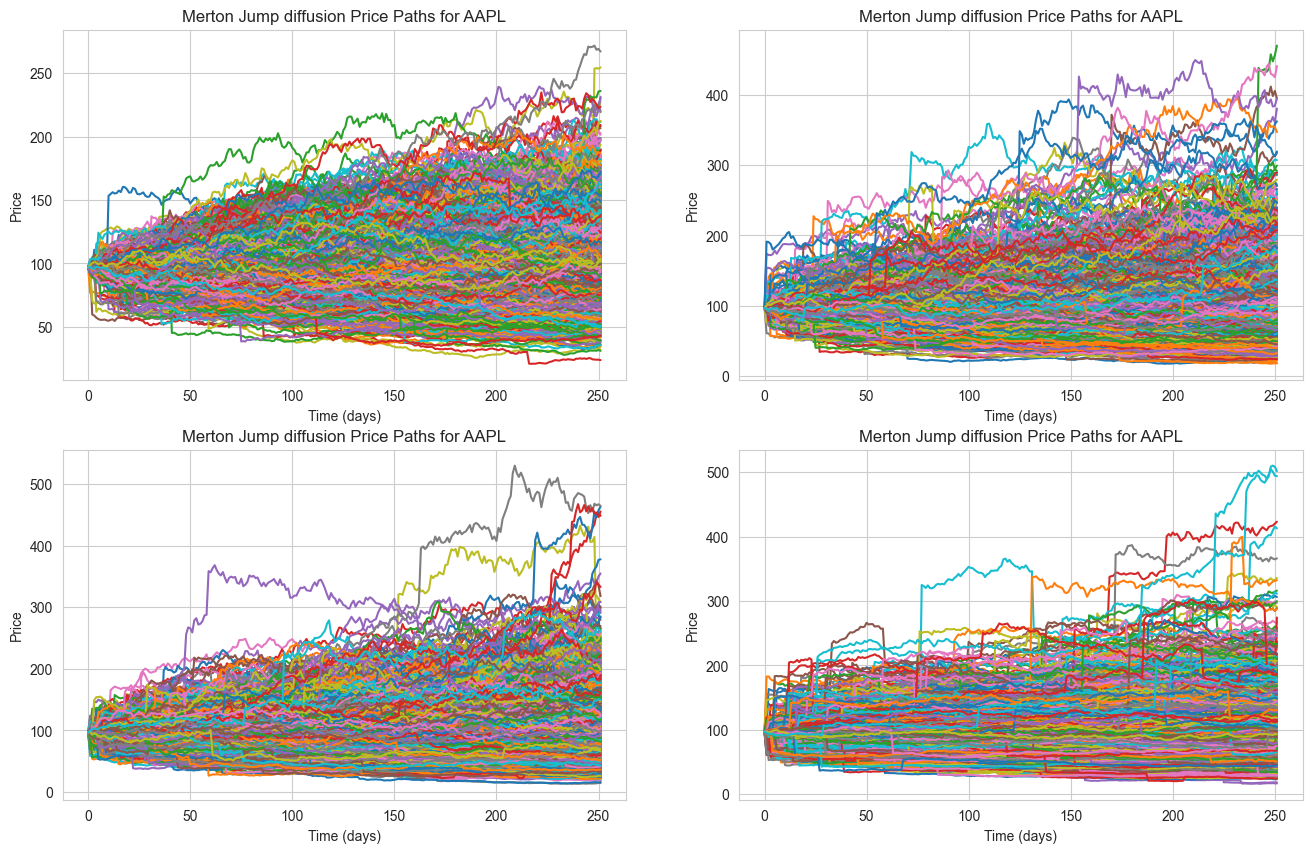

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

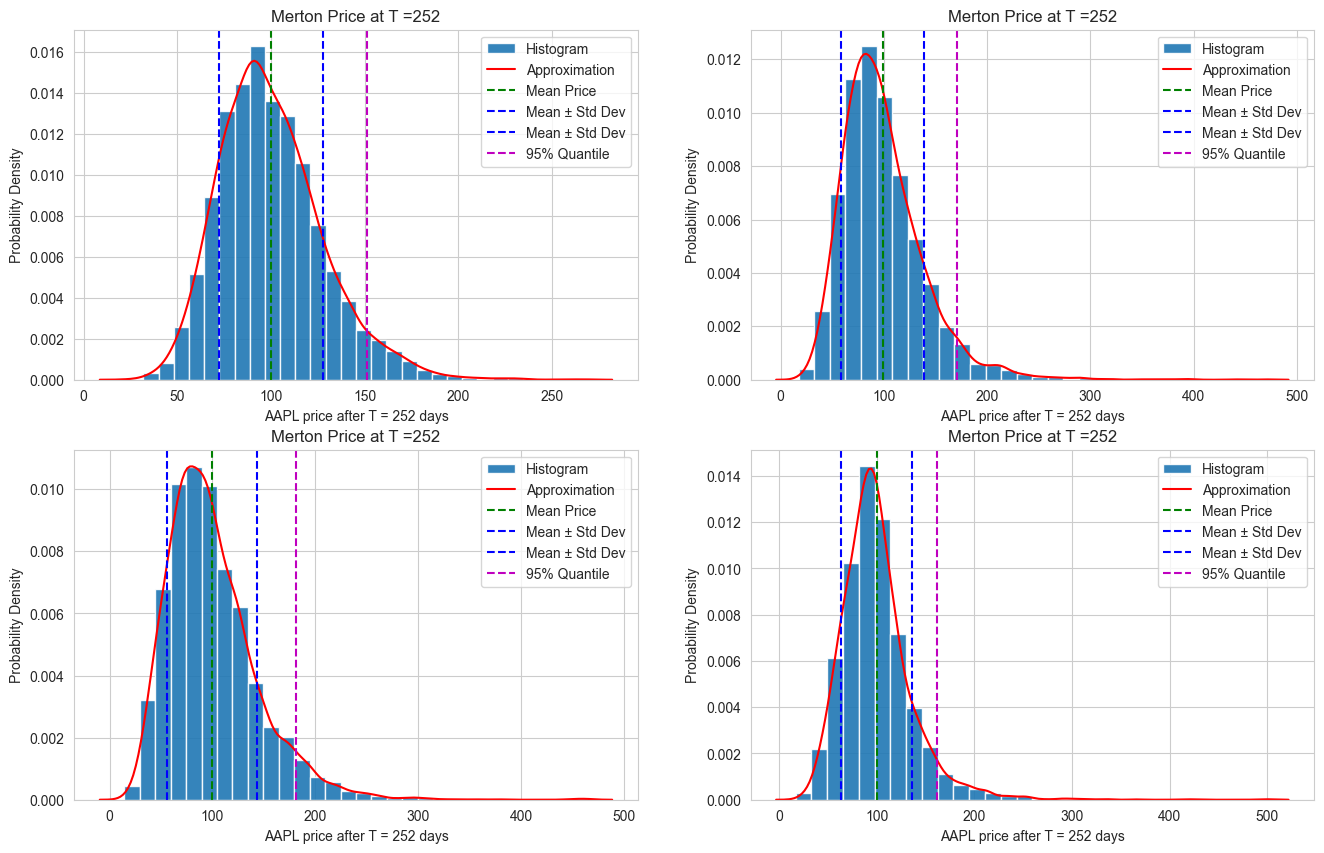

In [10]:
print(f'CALIBRATED PARAMETERS [σ\t\tλ\t\tm\t\tv]')
print(f'> European CALLS:\t {m_params_calls}')
print(f'> European PUTS:\t {m_params_puts}')
print(f'> OTKO DC:\t\t\t {m_params_otko}')
print(f'> MIXED:\t\t\t {m_params_mixed}')

Merton1 = Merton_pricer(S0, None, T, r, q, m_params_calls[0], m_params_calls[1], m_params_calls[2], m_params_calls[3], exercise)
Merton2 = Merton_pricer(S0, None, T, r, q, m_params_puts[0], m_params_puts[1], m_params_puts[2], m_params_puts[3], exercise)
Merton3 = Merton_pricer(S0, None, T, r, q, m_params_otko[0], m_params_otko[1], m_params_otko[2], m_params_otko[3], exercise)
Merton4 = Merton_pricer(S0, None, T, r, q, m_params_mixed[0], m_params_mixed[1], m_params_mixed[2], m_params_mixed[3], exercise)

SMerton1 = Merton1.MertonPath(days, paths)
SMerton2 = Merton2.MertonPath(days, paths)
SMerton3 = Merton3.MertonPath(days, paths)
SMerton4 = Merton4.MertonPath(days, paths)

# PLOT MONTE CARLO PATHS
fig1, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
Merton1.plotMertonPath(SMerton1, 'AAPL', ax=axes[0,0])
Merton2.plotMertonPath(SMerton2, 'AAPL', ax=axes[0,1])
Merton3.plotMertonPath(SMerton3, 'AAPL', ax=axes[1,0])
Merton4.plotMertonPath(SMerton4, 'AAPL', ax=axes[1,1])
plt.show()

# PLOT FINAL PRICE DISTRIBUTIONS
fig2, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
Merton1.plotMertonAtFixedTime(SMerton1, days-1, 'AAPL', ax = axes[0,0])
Merton2.plotMertonAtFixedTime(SMerton2, days-1, 'AAPL', ax = axes[0,1])
Merton3.plotMertonAtFixedTime(SMerton3, days-1, 'AAPL', ax = axes[1,0])
Merton4.plotMertonAtFixedTime(SMerton4, days-1, 'AAPL', ax = axes[1,1])

Then we show our options priced by the Merton model, using the parameters calibrated on the full set of European calls and One Touch Knockout Daily Cliquets.

In [11]:
avg_payoffs = []
for k in calls_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SMerton3[-1]:
        payoffs.append(Merton4.payoff_call(k, St))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(calls_calib_prices))
merton_cf_prices = np.zeros(len(calls_calib_prices))

for index in range(len(calls_calib_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    merton_cf_prices[index] = Merton4.closed_formula_call(calls_strikes[index])

calls_calib_prices['MERTON MC (%)'] = merton_mc_prices
calls_calib_prices['MERTON CF (%)'] = merton_cf_prices

avg_payoffs = []
for k in puts_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SMerton4[-1]:
        payoffs.append(Merton4.payoff_put(k, St))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(puts_calib_prices))
merton_cf_prices = np.zeros(len(puts_calib_prices))

for index in range(len(puts_calib_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    merton_cf_prices[index] = Merton4.closed_formula_put(puts_strikes[index])

puts_calib_prices['MERTON MC (%)'] = merton_mc_prices
puts_calib_prices['MERTON CF (%)'] = merton_cf_prices

avg_payoffs = []
for K1, K2 in otko_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SMerton3.T:
        payoffs.append(Merton4.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(otko_calib_prices))
merton_cf_prices = np.zeros(len(otko_calib_prices))

for index in range(len(otko_calib_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    merton_cf_prices[index] = Merton3.closed_formula_otko(otko_strikes[index][0], otko_strikes[index][1])

otko_calib_prices['MERTON MC (%)'] = merton_mc_prices
otko_calib_prices['MERTON CF (%)'] = merton_cf_prices

print(calls_calib_prices)
print('\n')
print(puts_calib_prices)
print('\n')
print(otko_calib_prices)

   STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC (%)  MERTON CF (%)
0    75.0    25.10   25.300    25.50      29.256475      27.243363
1    87.5    16.75   16.900    17.05      21.761731      18.792498
2    97.5    11.55   11.625    11.70      16.930771      13.591062
3   105.0     8.45    8.530     8.61      13.961892      10.612105
4   120.0     4.15    4.195     4.24       9.368402       6.559734


   STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC (%)  MERTON CF (%)
0    70.0     3.30    3.350     3.40       2.303948       2.273421
1    85.0     7.50    7.575     7.65       6.092542       6.016158
2    97.5    13.15   13.255    13.36      11.455827      11.419501
3   110.0    20.75   20.870    20.99      18.996951      18.972074
4   125.0    32.06   32.230    32.40      30.147242      30.141167


   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)  MERTON MC (%)  MERTON CF (%)
0  75   0         1.33         1.45         1.57       1.505763       1.479194
1  70   0         0.63         0.7

### Kou Jump Diffusion

CALIBRATED PARAMETERS: [σ		λ		p		η1		η2]
> European CALLS:	 [0.2441, 0.6554, 0.3733, 8.2551, 9.9373]
> European PUTS:	 [0.3414, 0.7704, 0.387, 5.4276, 9.9265]
> OTKO DC:			 [0.3501, 3.395, 0.132, 9.483, 9.073]
> MIXED:			 [0.19, 2.0515, 0.3314, 5.5114, 5.8348]


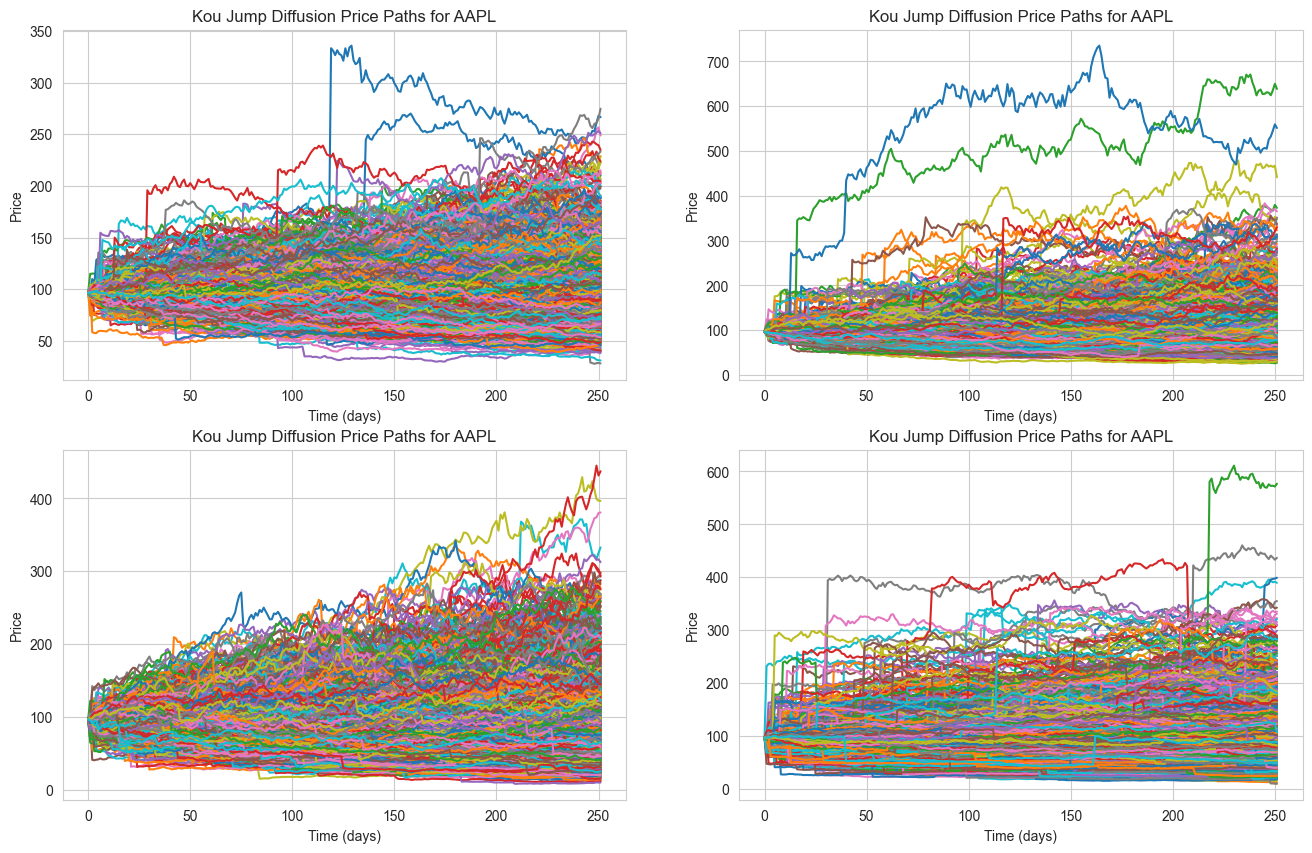

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

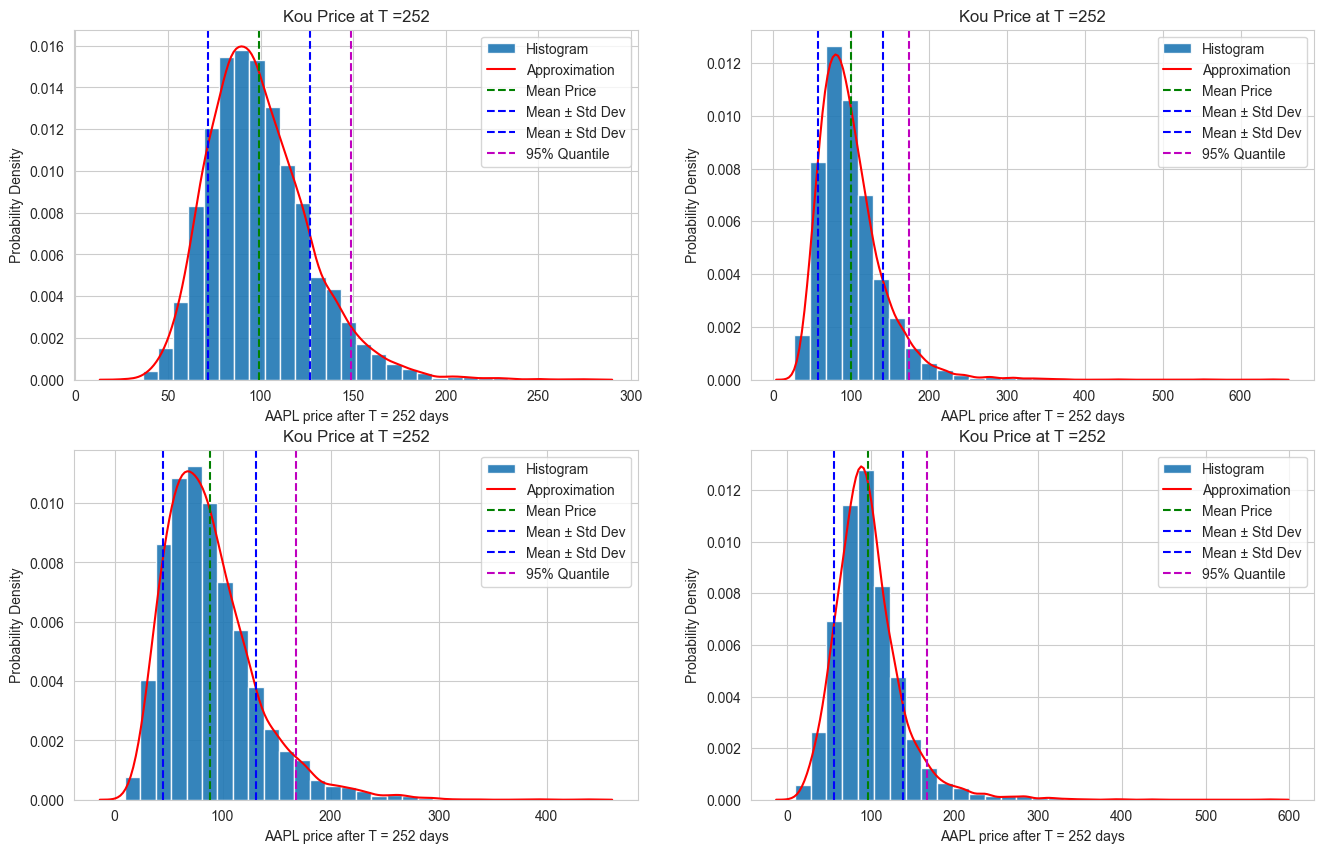

In [12]:
print(f'CALIBRATED PARAMETERS: [σ\t\tλ\t\tp\t\tη1\t\tη2]')
print(f'> European CALLS:\t {k_params_calls}')
print(f'> European PUTS:\t {k_params_puts}')
print(f'> OTKO DC:\t\t\t {k_params_otko}')
print(f'> MIXED:\t\t\t {k_params_mixed}')

Kou1 = Kou_pricer(S0, None, T, r, k_params_calls[0], k_params_calls[1], k_params_calls[2], k_params_calls[3], k_params_calls[4], exercise)
Kou2 = Kou_pricer(S0, None, T, r, k_params_puts[0], k_params_puts[1], k_params_puts[2], k_params_puts[3], k_params_puts[4], exercise)
Kou3 = Kou_pricer(S0, None, T, r, k_params_otko[0], k_params_otko[1], k_params_otko[2], k_params_otko[3], k_params_otko[4], exercise)
Kou4 = Kou_pricer(S0, None, T, r, k_params_mixed[0], k_params_mixed[1], k_params_mixed[2], k_params_mixed[3], k_params_mixed[4], exercise)

SKou1 = Kou1.KouPath(days, paths)
SKou2 = Kou2.KouPath(days, paths)
SKou3 = Kou3.KouPath(days, paths)
SKou4 = Kou4.KouPath(days, paths)

# PLOT MONTE CARLO PATHS
fig1, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
Kou1.plotKouPath(SKou1, 'AAPL', ax=axes[0,0])
Kou2.plotKouPath(SKou2, 'AAPL', ax=axes[0,1])
Kou3.plotKouPath(SKou3, 'AAPL', ax=axes[1,0])
Kou4.plotKouPath(SKou4, 'AAPL', ax=axes[1,1])
plt.show()

# PLOT FINAL PRICE DISTRIBUTIONS
fig2, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
Kou1.plotKouAtFixedTime(SKou1, days-1, 'AAPL', ax = axes[0,0])
Kou2.plotKouAtFixedTime(SKou2, days-1, 'AAPL', ax = axes[0,1])
Kou3.plotKouAtFixedTime(SKou3, days-1, 'AAPL', ax = axes[1,0])
Kou4.plotKouAtFixedTime(SKou4, days-1, 'AAPL', ax = axes[1,1])

Compute the otko final prices for Kou model

In [13]:
avg_payoffs = []
for k in calls_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SKou4[-1]:
        payoffs.append(Kou4.payoff_call(k, St))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(calls_calib_prices))
kou_cf_prices = np.zeros(len(calls_calib_prices))

for index in range(len(calls_calib_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    kou_cf_prices[index] = Kou4.closed_formula_call(calls_strikes[index])

calls_calib_prices['KOU MC (%)'] = kou_mc_prices
calls_calib_prices['KOU CF (%)'] = kou_cf_prices

avg_payoffs = []
for k in puts_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SKou4[-1]:
        payoffs.append(Kou4.payoff_put(k, St))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(puts_calib_prices))
kou_cf_prices = np.zeros(len(puts_calib_prices))

for index in range(len(puts_calib_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    kou_cf_prices[index] = Kou4.closed_formula_put(puts_strikes[index])

puts_calib_prices['KOU MC (%)'] = kou_mc_prices
puts_calib_prices['KOU CF (%)'] = kou_cf_prices

avg_payoffs = []
for K1, K2 in otko_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SKou4.T:
        payoffs.append(Kou4.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(otko_calib_prices))
kou_cf_prices = np.zeros(len(otko_calib_prices))

for index in range(len(otko_calib_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    kou_cf_prices[index] = Kou4.closed_formula_otko2(otko_strikes[index][0], otko_strikes[index][1])

otko_calib_prices['KOU MC (%)'] = kou_mc_prices
otko_calib_prices['KOU CF (%)'] = kou_cf_prices

In [14]:
selection1 = [0,1,2,3,6,7]
print(f'>> CALLS\n{calls_calib_prices.iloc[:, selection1]}')
print(f'>> PUTS\n{puts_calib_prices.iloc[:, selection1]}')
selection2 = [0,1,2,3,4,7,8]
print(f'\n>> OTKO\n{otko_calib_prices.iloc[:, selection2]}')

>> CALLS
   STRIKE  MKT_BID  MKT_MID  MKT_ASK  KOU MC (%)  KOU CF (%)
0    75.0    25.10   25.300    25.50   26.384878   28.331013
1    87.5    16.75   16.900    17.05   18.629946   20.281060
2    97.5    11.55   11.625    11.70   13.869666   15.238396
3   105.0     8.45    8.530     8.61   11.102089   12.260301
4   120.0     4.15    4.195     4.24    7.209937    8.041045
>> PUTS
   STRIKE  MKT_BID  MKT_MID  MKT_ASK  KOU MC (%)  KOU CF (%)
0    70.0     3.30    3.350     3.40    3.625013    3.182935
1    85.0     7.50    7.575     7.65    8.205755    7.437460
2    97.5    13.15   13.255    13.36   14.179832   13.066836
3   110.0    20.75   20.870    20.99   22.036289   20.579732
4   125.0    32.06   32.230    32.40   33.261022   31.554936

>> OTKO
   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)  KOU MC (%)  KOU CF (%)
0  75   0         1.33         1.45         1.57    2.414423    2.443178
1  70   0         0.63         0.71         0.78    1.568736    1.587953
2  85  75         2.67 

#### Variance Gamma model

CALIBRATED PARAMETERS: [σ 		θ		 v]
> European CALLS:	 [0.2781, 0.1335, 0.1808]
> European PUTS:	 [0.3889, 0.0089, 0.178]
> OTKO DC:			 [0.3732, -0.118, 0.252]
> MIXED:			 [0.3377, -0.048, 0.4345]
CALIBRATED PARAMETERS: [μ_p	 μ_n	v_p	v_n]
> European CALLS:	 [0.534, 0.401, 0.052, 0.029]
> European PUTS:	 [0.656, 0.647, 0.077, 0.075]
> OTKO DC:			 [0.47, 0.588, 0.056, 0.087]
> MIXED:			 [0.339, 0.387, 0.05, 0.065]


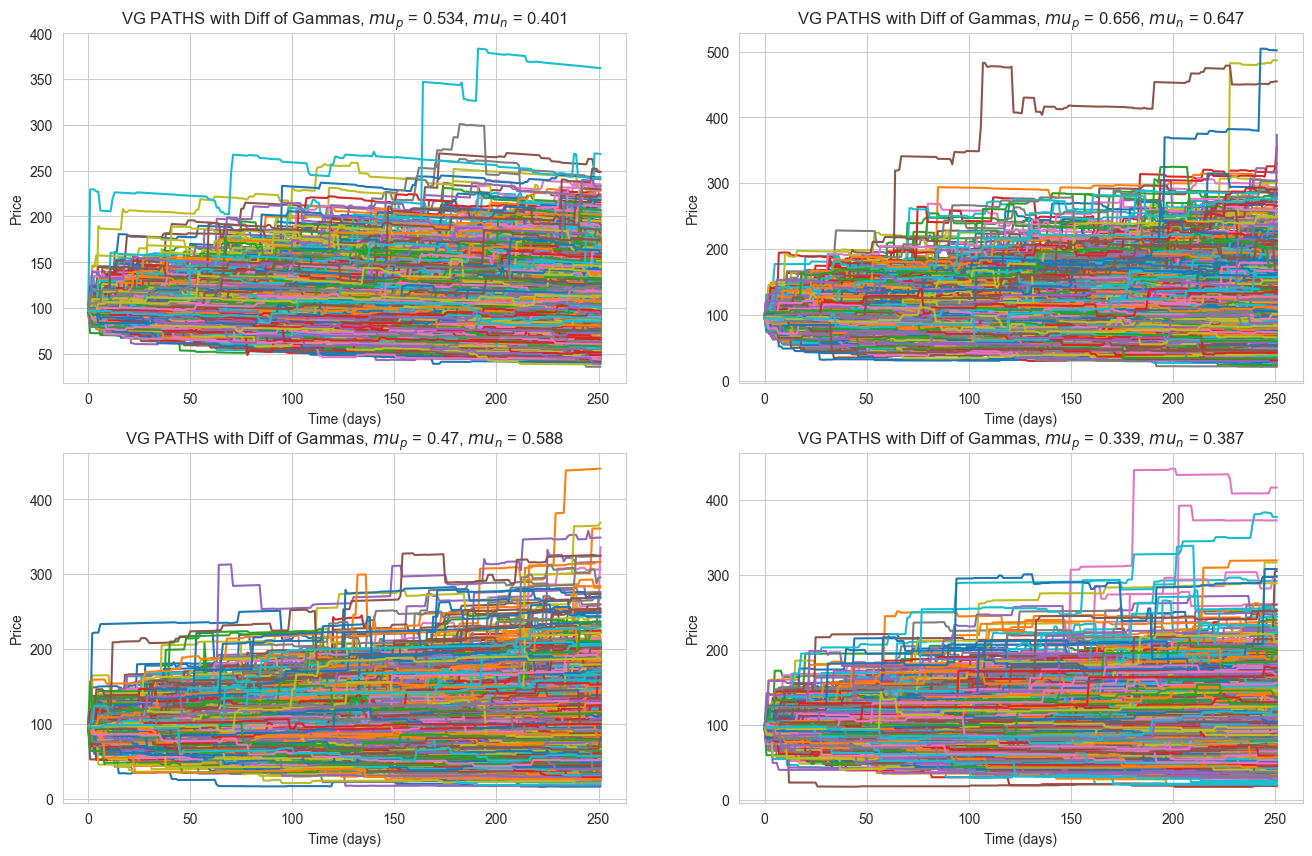

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

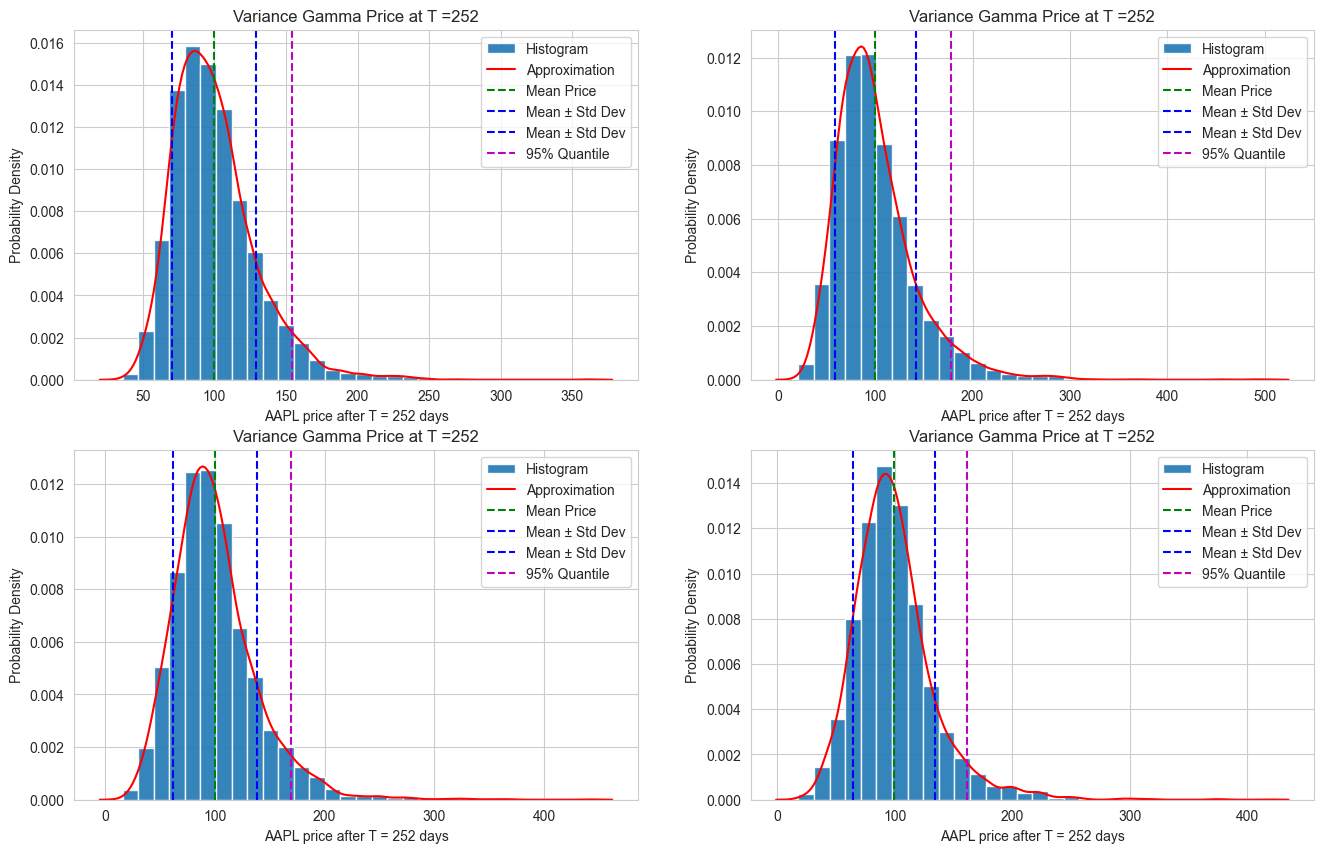

In [15]:
VG1 = VG_pricer(S0, None, T, r, q, vg_params_calls[0], vg_params_calls[1], vg_params_calls[2],  exercise)
VG2 = VG_pricer(S0, None, T, r, q, vg_params_puts[0], vg_params_puts[1], vg_params_puts[2],  exercise)
VG3 = VG_pricer(S0, None, T, r, q, vg_params_otko[0], vg_params_otko[1], vg_params_otko[2], exercise)
VG4 = VG_pricer(S0, None, T, r, q, vg_params_mixed[0], vg_params_mixed[1], vg_params_mixed[2], exercise)

print(f'CALIBRATED PARAMETERS: [σ \t\tθ\t\t v]')
print(f'> European CALLS:\t {vg_params_calls}')
print(f'> European PUTS:\t {vg_params_puts}')
print(f'> OTKO DC:\t\t\t {vg_params_otko}')
print(f'> MIXED:\t\t\t {vg_params_mixed}')

vg_params_calls2 = [VG1.get_mu_p, VG1.get_mu_n, VG1.get_nu_p, VG1.get_nu_n]
vg_params_puts2 = [VG2.get_mu_p, VG2.get_mu_n, VG2.get_nu_p, VG2.get_nu_n]
vg_params_otko2 = [VG3.get_mu_p, VG3.get_mu_n, VG3.get_nu_p, VG3.get_nu_n]
vg_params_mixed2 = [VG4.get_mu_p, VG4.get_mu_n, VG4.get_nu_p, VG4.get_nu_n]

for i in range(len(vg_params_calls2)):
    vg_params_calls2[i] = round(vg_params_calls2[i], 3)
    vg_params_puts2[i] = round(vg_params_puts2[i], 3)
    vg_params_otko2[i] = round(vg_params_otko2[i], 3)
    vg_params_mixed2[i] = round(vg_params_mixed2[i], 3)

print(f'CALIBRATED PARAMETERS: [μ_p\t μ_n\tv_p\tv_n]')
print(f'> European CALLS:\t {vg_params_calls2}')
print(f'> European PUTS:\t {vg_params_puts2}')
print(f'> OTKO DC:\t\t\t {vg_params_otko2}')
print(f'> MIXED:\t\t\t {vg_params_mixed2}')

SVG1 = VG1.VarianceGammaPath2(days, paths)
SVG2 = VG2.VarianceGammaPath2(days, paths)
SVG3 = VG3.VarianceGammaPath2(days, paths)
SVG4 = VG4.VarianceGammaPath2(days, paths)

# PLOT MONTE CARLO PATHS
fig1, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
VG1.plotVGPath(SVG1, 'AAPL', method='Diff of Gammas', ax=axes[0,0])
VG2.plotVGPath(SVG2, 'AAPL',method='Diff of Gammas', ax=axes[0,1])
VG3.plotVGPath(SVG3, 'AAPL', method='Diff of Gammas', ax=axes[1,0])
VG4.plotVGPath(SVG4, 'AAPL', method='Diff of Gammas', ax=axes[1,1])
plt.tight_layout()
plt.show()


# PLOT FINAL PRICE DISTRIBUTIONS
fig2, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
VG1.plotVGAtFixedTime(SVG1, 251, 'AAPL', ax = axes[0,0])
VG2.plotVGAtFixedTime(SVG2, 251, 'AAPL', ax = axes[0,1])
VG3.plotVGAtFixedTime(SVG3, 251, 'AAPL', ax = axes[1,0])
VG4.plotVGAtFixedTime(SVG4, 251, 'AAPL', ax = axes[1,1])

In [32]:
avg_payoffs = []
for k in calls_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SVG4[-1]:
        payoffs.append(VG4.payoff_call(k, St))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(calls_calib_prices))
vg_cf_prices = np.zeros(len(calls_calib_prices))

for index in range(len(calls_calib_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    vg_cf_prices[index] = VG4.closed_formula_call(calls_strikes[index])

calls_calib_prices['VG MC (%)'] = vg_mc_prices
calls_calib_prices['VG CF (%)'] = vg_cf_prices

avg_payoffs = []
for k in puts_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SVG4[-1]:
        payoffs.append(VG4.payoff_put(k, St))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(puts_calib_prices))
vg_cf_prices = np.zeros(len(puts_calib_prices))

for index in range(len(puts_calib_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    vg_cf_prices[index] = VG4.closed_formula_put(puts_strikes[index])

puts_calib_prices['VG MC (%)'] = vg_mc_prices
puts_calib_prices['VG CF (%)'] = vg_cf_prices

avg_payoffs = []
for K1, K2 in otko_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SVG4.T:
        payoffs.append(VG4.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(otko_calib_prices))
vg_cf_prices = np.zeros(len(otko_calib_prices))

for index in range(len(otko_calib_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    vg_cf_prices[index] = VG4.closed_formula_otko6(otko_strikes[index][0], otko_strikes[index][1])

otko_calib_prices['VG MC (%)'] = vg_mc_prices
otko_calib_prices['VG CF (%)'] = vg_cf_prices

In [33]:
selection1 = [0,1,2,3,8,9]
print(f'>> CALLS\n{calls_calib_prices.iloc[:, selection1]}')
print(f'>> CALLS\n{puts_calib_prices.iloc[:, selection1]}')
selection2 = [0,1,2,3,4,9,10]
print(f'\n>> OTKO\n{otko_calib_prices.iloc[:, selection2]}')

>> CALLS
   STRIKE  MKT_BID  MKT_MID  MKT_ASK  VG MC (%)  VG CF (%)
0    75.0    25.10   25.300    25.50  26.387478  26.851199
1    87.5    16.75   16.900    17.05  18.013316  18.568189
2    97.5    11.55   11.625    11.70  12.858242  13.631821
3   105.0     8.45    8.530     8.61   9.876757  10.827197
4   120.0     4.15    4.195     4.24   5.790298   6.939628
>> CALLS
   STRIKE  MKT_BID  MKT_MID  MKT_ASK  VG MC (%)  VG CF (%)
0    70.0     3.30    3.350     3.40   2.135682   1.892958
1    85.0     7.50    7.575     7.65   5.950064   5.737247
2    95.0    11.90   11.970    12.04  10.150696  10.130970
3    97.5    13.15   13.255    13.36  11.416656  11.460260
4   110.0    20.75   20.870    20.99  18.952498  19.268561
5   125.0    32.06   32.230    32.40  30.119255  30.534816

>> OTKO
   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)  VG MC (%)  VG CF (%)
0  75   0         1.33         1.45         1.57   1.319361   1.278508
1  70   0         0.63         0.71         0.78   0.739180   0.

In [34]:
print(calls_calib_prices)
print(puts_calib_prices)
print(otko_calib_prices)

   STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC (%)  MERTON CF (%)  \
0    75.0    25.10   25.300    25.50      27.453268      27.243363   
1    87.5    16.75   16.900    17.05      19.218356      18.792498   
2    97.5    11.55   11.625    11.70      13.960828      13.591062   
3   105.0     8.45    8.530     8.61      10.812254      10.612105   
4   120.0     4.15    4.195     4.24       6.257337       6.559734   

   KOU MC (%)  KOU CF (%)  VG MC (%)  VG CF (%)  
0   26.873840   28.331013  26.387478  26.851199  
1   19.061491   20.281060  18.013316  18.568189  
2   14.202360   15.238396  12.858242  13.631821  
3   11.344134   12.260301   9.876757  10.827197  
4    7.373268    8.041045   5.790298   6.939628  
   STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC (%)  MERTON CF (%)  \
0    70.0     3.30    3.350     3.40       2.519955       2.273421   
1    85.0     7.50    7.575     7.65       6.263849       6.016158   
2    95.0    11.90   11.970    12.04      10.413326      10.157817   